# Análise Exploratória dos Dados (Conjunto com a variável resposta do modelo)

### Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
import mplfinance as mpf
from app.settings import Settings

### Importação da Base de Dados

In [3]:
settings = Settings()
data = pd.read_csv(settings.DOWNLOAD_PATH+'/'+settings.NEW_NASDAQ_FILE)

### Tratamento das Variáveis

In [4]:
# Remover o símbolo '$' e substituir ',' por '.' nas colunas de preços, convertendo-as para float
columns_to_convert = ['Close/Last', 'Open', 'High', 'Low']

for col in columns_to_convert:
    data[col] = data[col].replace('[\$,]', '', regex=True).str.replace(',', '.').astype(float)

# Conversão da coluna 'Date' para datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Verificar se a conversão foi bem-sucedida
print(data[columns_to_convert].dtypes)
print(data.head())

Close/Last    float64
Open          float64
High          float64
Low           float64
dtype: object
        Date  Close/Last    Volume    Open      High     Low
0 2024-11-12      208.91  38942920  208.37  209.5400  206.01
1 2024-11-11      206.84  35456010  208.50  209.6500  205.59
2 2024-11-08      208.18  36075850  209.72  209.9633  207.44
3 2024-11-07      210.05  52878380  207.44  212.2500  207.19
4 2024-11-06      207.09  72292170  200.01  207.5500  199.14


<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:5: SyntaxWarning: invalid escape sequence '\$'
C:\Users\biel_\AppData\Local\Temp\ipykernel_14464\1998124349.py:5: SyntaxWarning: invalid escape sequence '\$'
  data[col] = data[col].replace('[\$,]', '', regex=True).str.replace(',', '.').astype(float)


In [17]:
forecast_days=30
threshold=0.03 

# Criar variável alvo
dataset = data.copy()    
dataset['Future_Return'] = (dataset['Close/Last'].shift(-forecast_days) - dataset['Close/Last']) / dataset['Close/Last']
dataset['Target'] = (dataset['Future_Return'] > threshold).astype(int)

# Remover valores nulos
dataset.dropna(inplace=True)

# Criar features adicionais
dataset['forca_relativa'] = (dataset['Close/Last'] - dataset['Low'])/ (dataset['High'] - dataset['Low'])
dataset['SMA_20'] = dataset['Future_Return'].rolling(window=20,closed='left').mean()
dataset['SMA_50'] = dataset['Future_Return'].rolling(window=50,closed='left').mean()
dataset['Volatility_30'] = dataset['Future_Return'].rolling(window=30,closed='left').std()
dataset['Avg_Volume_30'] = dataset['Volume'].rolling(window=30,closed='left').mean()
dataset['forca_relativa_30'] = dataset['forca_relativa'].rolling(window=30,closed='left').mean()    

In [18]:
#Tirando os missings 
dataset.dropna(inplace=True)

In [19]:
#Estatísticas Descritivas
dataset[['Target','SMA_20', 'SMA_50', 'Volatility_30', 'Avg_Volume_30','forca_relativa_30']].describe()

,Target,SMA_20,SMA_50,Volatility_30,Avg_Volume_30,forca_relativa_30
count,2436.000000,2436.000000,2436.000000,2436.000000,2.436000e+03,2436.000000
mean,0.241379,-0.024153,-0.024035,0.055911,7.696377e+07,0.523259
std,0.428008,0.092749,0.072229,0.032902,2.429837e+07,0.053729
min,0.000000,-0.213924,-0.149615,0.011908,3.371659e+07,0.379957
25%,0.000000,-0.081378,-0.074092,0.032191,6.005334e+07,0.485666
50%,0.000000,-0.036238,-0.031486,0.048313,7.278658e+07,0.521214
75%,0.000000,0.021454,0.009294,0.068698,8.833861e+07,0.558690
max,1.000000,0.441757,0.242018,0.248637,1.595049e+08,0.695629


In [20]:
#Dados desbalanceados - se está subindo conforme nossa target no tempo determinado 
dataset.Target.value_counts(normalize=True) 

Target
0    0.758621
1    0.241379
Name: proportion, dtype: float64

### Análise das variáveis

                     Target    SMA_20    SMA_50  Volatility_30  Avg_Volume_30  \
Target             1.000000  0.542443  0.300140       0.322301       0.121327   
SMA_20             0.542443  1.000000  0.744011       0.406786       0.179988   
SMA_50             0.300140  0.744011  1.000000       0.422531       0.162896   
Volatility_30      0.322301  0.406786  0.422531       1.000000       0.301050   
Avg_Volume_30      0.121327  0.179988  0.162896       0.301050       1.000000   
forca_relativa_30 -0.021867 -0.215185 -0.487648      -0.124533      -0.072983   

                   forca_relativa_30  
Target                     -0.021867  
SMA_20                     -0.215185  
SMA_50                     -0.487648  
Volatility_30              -0.124533  
Avg_Volume_30              -0.072983  
forca_relativa_30           1.000000  


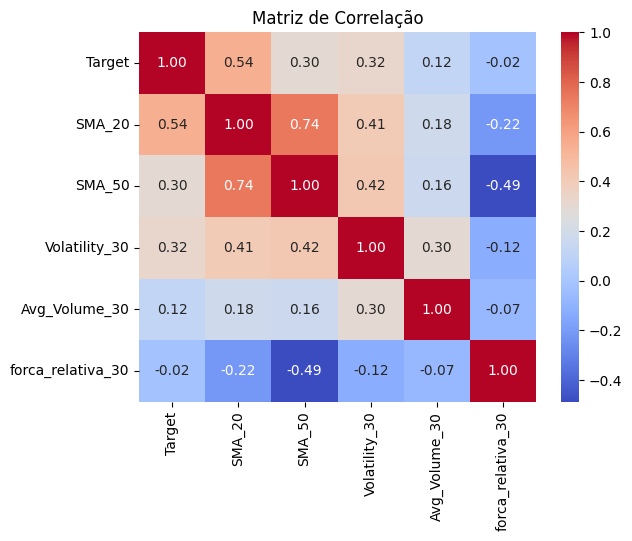

In [21]:
# Matriz de correlação
correlation_matrix = dataset[['Target','SMA_20', 'SMA_50', 'Volatility_30', 'Avg_Volume_30','forca_relativa_30']].corr()
print(correlation_matrix)

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

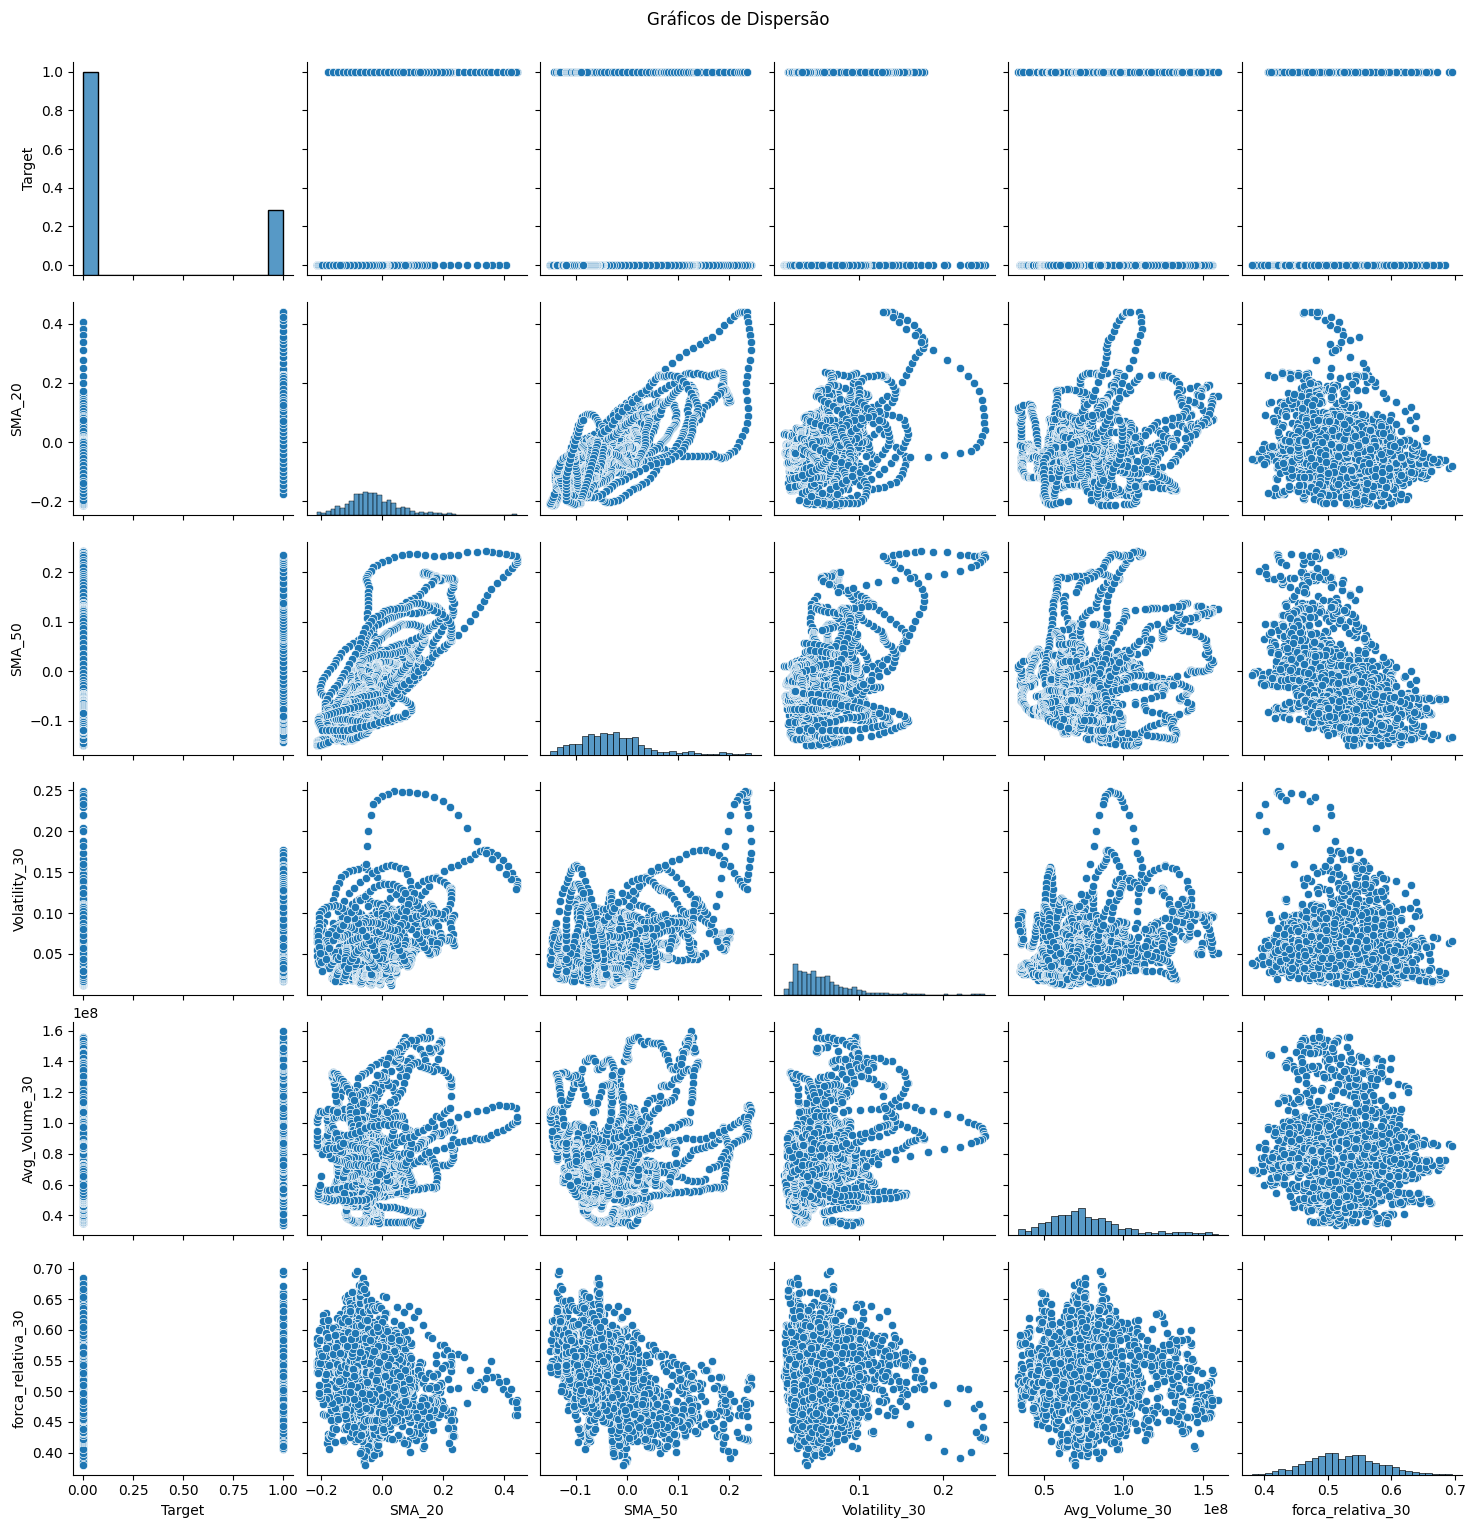

In [22]:
# Pares de dispersão
sns.pairplot(dataset[['Target','SMA_20', 'SMA_50', 'Volatility_30', 'Avg_Volume_30','forca_relativa_30']])
plt.suptitle("Gráficos de Dispersão", y=1.02)
plt.show()